In [ ]:
import snapatac2 as snap
import pandas as pd
import numpy as np 
import polars as pl 
import os
import scanpy as sc

In [ ]:
# i ran this code in cluster 

In [ ]:
import snapatac2 as snap
data = snap.read("/scratch/fatemeh.nasrabadi/importsnt/THESIS_FINAL/10Samples/10Samples_agg_ATAC_tumor_annotated.h5ad")

In [ ]:
snap.tl.macs3(data, groupby='site',  max_frag_size = 120) 

In [ ]:
data.colose()

In [ ]:
# these code were run on posit

In [ ]:
data = snap.read("/scratch/fatemeh.nasrabadi/importsnt/THESIS_FINAL/10Samples/10Samples_agg_ATAC_tumor_annotated.h5ad")

In [ ]:
data.uns['reference_sequences'] = t.uns['reference_sequences'] 

In [ ]:
data.write("/scratch/fatemeh.nasrabadi/importsnt/THESIS_FINAL/10Samples/10Samples_agg_ATAC_tumor_annotated.h5ad")

In [ ]:
data.close()

In [ ]:
peaks = snap.tl.merge_peaks(data.uns['macs3'], snap.genome.hg38)

In [ ]:
peaks

In [ ]:
peak_mat = snap.pp.make_peak_matrix(data, use_rep=peaks['Peaks'])

In [ ]:
group1 = "Peri" 
group2 = "Core"
peri = data.obs['site'] == group1
core = data.obs['site'] == group2
peaks_selected = np.logical_or(
    peaks[group1].to_numpy(),
    peaks[group2].to_numpy(),
)


In [ ]:
%%time
diff_peaks = snap.tl.diff_test(
    peak_mat,
    cell_group1=peri,
    cell_group2=core,
    features=peaks_selected,
)

In [ ]:
diff_peaks

import polars as pl

diff_peaks.write_csv("RUN2/diff_peaksDec.csv")

In [29]:
# read the peaks 
!pwd

/home/fatemeh.nasrabadi


In [31]:
import pandas as pd

# read your file
df = pd.read_csv("/home/fatemeh.nasrabadi/ROVIGO_congas/final/RUN2/diff_peaksDec.csv")

# 1) remove chrX peaks
df_no_chrX = df[~df["feature name"].str.lower().str.startswith("chrx")]

# 2) filter for adjusted p-value < 0.01
df_filtered = df_no_chrX[df_no_chrX["adjusted p-value"] < 0.01]

# check how many remain
print("Original:", len(df))
print("Without chrX:", len(df_no_chrX))
print("After p_adj < 0.01:", len(df_filtered))

# 3) save
df_filtered.to_csv("diff_peaks_no_chrX_padj001_Dec.csv", index=False)


Original: 85434
Without chrX: 82776
After p_adj < 0.01: 33458


In [ ]:
!pwd

In [ ]:
import polars as pl
diff_peaks.write_csv("/home/fatemeh.nasrabadi/ROVIGO_congas/final/diff_peaks_no_chrX_padj001_Dec.csv")

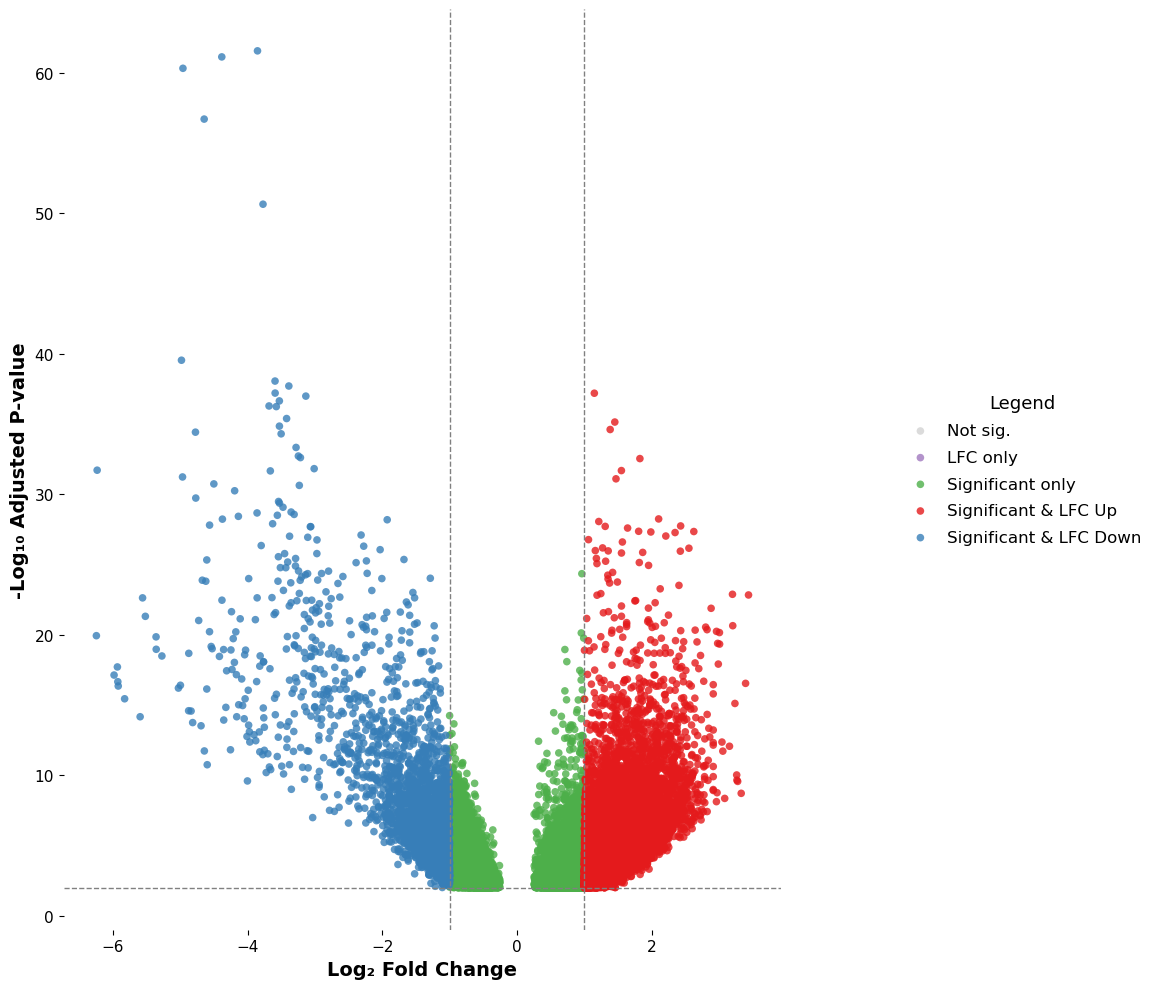

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from adjustText import adjust_text

# <<< set this to your DataFrame >>>
df_raw = df_filtered  # e.g. df_raw = pd.read_csv("RUN2/diff_peaks10S.csv")

# Copy & prepare
df = df_raw.copy()
df = df.dropna(subset=['adjusted p-value'])
df['-log10(padj)'] = -np.log10(df['adjusted p-value'])

# Categorize points
df['category'] = 'Not sig.'
df.loc[(df['adjusted p-value'] < 0.01) & (df['log2(fold_change)'] >= 1),  'category'] = 'Significant & LFC Up'
df.loc[(df['adjusted p-value'] < 0.01) & (df['log2(fold_change)'] <= -1), 'category'] = 'Significant & LFC Down'
df.loc[(df['adjusted p-value'] < 0.01) & (df['category'] == 'Not sig.'), 'category'] = 'Significant only'
df.loc[(df['adjusted p-value'] >= 0.01) & (df['log2(fold_change)'].abs() >= 1), 'category'] = 'LFC only'

# Colors
color_map = {
    'Not sig.': '#D3D3D3',
    'LFC only': '#a078bf',
    'Significant only': '#4daf4a',
    'Significant & LFC Up': '#e41a1c',
    'Significant & LFC Down': '#377eb8'
}

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

for category, color in color_map.items():
    subset = df[df['category'] == category]
    ax.scatter(
        subset['log2(fold_change)'],
        subset['-log10(padj)'],
        label=category,
        color=color,
        s=30,
        alpha=0.8,
        edgecolor='none'
    )

# Thresholds
ax.axhline(-np.log10(0.01), color='gray', linestyle='--', linewidth=1)
ax.axvline(1,  color='gray', linestyle='--', linewidth=1)
ax.axvline(-1, color='gray', linestyle='--', linewidth=1)

# # Top labels (more positives than negatives as you had)
# top_up = df[df['category'] == 'Significant & LFC Up'].nlargest(40, '-log10(padj)')
# top_down = df[df['category'] == 'Significant & LFC Down'].nlargest(20, '-log10(padj)')

# texts = []
# for _, row in pd.concat([top_up, top_down]).iterrows():
#     texts.append(ax.text(
#         row['log2(fold_change)'], row['-log10(padj)'], row['feature name'],
#         fontsize=8, weight='bold', ha='center', va='bottom'
#     ))

# adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))

# Labels & title
ax.set_xlabel("Log₂ Fold Change", fontsize=14, weight='bold')
ax.set_ylabel("-Log₁₀ Adjusted P-value", fontsize=14, weight='bold')
ax.set_title("", fontsize=16, weight='bold')

# Legend
ax.legend(
    title='Legend',
    title_fontsize=13,
    fontsize=12,
    loc='center left',
    bbox_to_anchor=(1.15, 0.5),
    frameon=False,
    labelspacing=0.7,
    handletextpad=0.6,
    borderaxespad=0.5
)

ax.tick_params(labelsize=11)
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()


In [33]:
n_up   = (df['category'] == 'Significant & LFC Up').sum()
n_down = (df['category'] == 'Significant & LFC Down').sum()

print("Significant & LFC Up  :", n_up)
print("Significant & LFC Down:", n_down)

Significant & LFC Up  : 13489
Significant & LFC Down: 2690


In [7]:
## motif enrichment

In [ ]:
df_filtered = df[df["adjusted p-value"] < 0.01]

In [8]:
# with p adj 1 and -1

In [ ]:
df = df_filtered 
peaks = {
    "Peri": df_filtered.loc[
        df_filtered["log2(fold_change)"] > 1,
        "feature name"
    ].to_numpy()

#     "Core": df_filtered.loc[
#         df_filtered["log2(fold_change)"] < 0,
#         "feature name"
#     ].to_numpy(),
}


In [ ]:
df = df_filtered 
core_background_list = df_filtered.loc[
    df_filtered["log2(fold_change)"] < -1, 
    "feature name"
].tolist()



In [ ]:
core_background_list

In [ ]:
#background format should be a list of peaks in core for example 
# Motif enrichment analysis
motifs_peri = snap.tl.motif_enrichment(
            motifs=snap.datasets.cis_bp(unique=True),
            regions=peaks,background = core_background_list , 
            genome_fasta=snap.genome.hg38
        )

In [ ]:
motifs  = motifs_peri 
# Save motifs for tumor cells
motifs_peri = pd.DataFrame({
            'index': motifs["Peri"]['name'].to_list(),
            'LFC': motifs["Peri"]['log2(fold change)'].to_list(),
            'padj': motifs["Peri"]['adjusted p-value'].to_list()
        }).set_index('index')

import pandas as pd
motifs_peri.to_csv("RUN2/motifs_peri_10backgroundcheck_Dec.csv")  # index=False to skip row numbers

In [ ]:
# Save motifs for tumor cells
motifs_peri = pd.DataFrame({
            'index': motifs["Peri"]['name'].to_list(),
            'LFC': motifs["Peri"]['log2(fold change)'].to_list(),
            'padj': motifs["Peri"]['adjusted p-value'].to_list()
        }).set_index('index')

In [ ]:

import pandas as pd

motifs_peri.to_csv("RUN2/motifs_peri_10_Dec.csv")  # index=False to skip row numbers

In [ ]:
import pandas as pd
import numpy as np

# Read CSV
df = pd.read_csv("RUN2/motifs_peri_10_Dec.csv")

# Make sure LFC is numeric
df["LFC"] = pd.to_numeric(df["LFC"], errors="coerce")

# Identify infinite values
mask_inf = np.isinf(df["LFC"])

# Replace them with random numbers between 3.4 and 4.0
df.loc[mask_inf, "LFC"] = np.random.uniform(3.4, 4.0, mask_inf.sum())

# Save updated CSV
#df.to_csv("RUN2/motifs_peri_10_Dec_corrected.csv", index=False)

print("Replaced", mask_inf.sum(), "infinite LFC values.")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file


# Filter for adjusted p-value < 0.01
filtered_df = df[df['padj'] < 0.01]

# Select top 20 regions with LFC > 1
top_up = filtered_df[filtered_df['LFC'] > 1].nlargest(20, 'LFC')

# Select top 20 regions with LFC < -1
top_down = filtered_df[filtered_df['LFC'] < -1].nsmallest(20, 'LFC')

# Combine both for plotting
top_combined = pd.concat([top_up, top_down])
top_combined = top_combined.rename(columns={'index': 'gene', 'LFC': 'log2(fold_change)'})

# Plotting
plt.figure(figsize=(6, 12))
plt.barh(
    top_combined['gene'],
    top_combined['log2(fold_change)'],
    color=['red' if x > 0 else 'blue' for x in top_combined['log2(fold_change)']]
)
plt.axvline(0, color='black', linewidth=0.8)
plt.xlabel('log2(Fold Change)')
plt.title('Top 20 TFs Core vs. perimarginal')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Read the CSV file


# Keep only significant TFs
filtered_df = df[df["padj"] < 0.01].copy()

# All Peri-enriched TFs: LFC > 1
peri_genes = filtered_df.loc[filtered_df["LFC"] > 1, "index"].tolist()

# All Core-enriched TFs: LFC < -1
core_genes = filtered_df.loc[filtered_df["LFC"] < -1, "index"].tolist()

# Combined (same genes used in the plot), sorted by LFC
combined = filtered_df[
    (filtered_df["LFC"] > 1) | (filtered_df["LFC"] < -1)
].copy()

combined = combined.rename(columns={"index": "gene", "LFC": "log2(fold_change)"})
combined = combined.sort_values("log2(fold_change)", ascending=True)

all_genes_plotted = combined["gene"].tolist()

print("=== Peri-enriched TFs (LFC > 1) ===")
print(peri_genes)
print()

print("=== Core-enriched TFs (LFC < -1) ===")
print(core_genes)
print()

print("=== All genes plotted (ordered as in plot) ===")
print(all_genes_plotted)


In [ ]:
Neural-related:
BHLHE22, BHLHE23, CUX2, DMRT1, DMRT3, DMRTA2, GRHL1, HOXA3, HOXB3, HOXD11,
IRX1, LMX1A, LMX1B, MEIS3, NEUROG1, NEUROG2, NKX2-2, ONECUT3, OTX2,
PAX4, PAX7, PBX1, PROX1, RORA, RORB, SIX6, SOX14, SOX15, SRY, TFCP2

Oligodendrocyte / glial related:
OLIG1, OLIG2, OLIG3, NKX2-2, SOX14, SOX15

In [ ]:
| Category                                               | Genes                                                                                                                                                                         |
| ------------------------------------------------------ | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Proliferation / Cell-cycle / Cancer growth**         | E2F4, E2F5, E2F6, TFDP1/2/3, KLF1/3/4/5/6/7/9/10/11/12/13/14/15, CTCF, CTCFL, DNMT1, NFYA, NFYB, SP1–SP9, WT1, HOXA10, HOXA11, HOXC11, HOXC13, HOXB13, HOXD10, LIN28A, LIN28B |
| **Hypoxia / Metabolic stress**                         | HIF1A, EPAS1 (HIF2A), NFE2L1, NFE2L2 (NRF2), MAFK, NFE2                                                                                                                       |
| **Stress response (AP-1, ER stress, immediate early)** | FOS, FOSB, FOSL1, FOSL2, JDP2, JUNB, JUND, ATF1, ATF2, ATF6B, ATF7, CREB1, CREB3, HES1, HES4, BACH1, BACH2, ERF, HINFP, GMEB1, TIGD2                                          |
| **Inflammatory / Immune**                              | STAT1, STAT3, STAT5A, BATF3, ELF1, ELF3, ELF4, GABPA, IKZF4, ZFP57, ZBTB7A, ZBTB7B, TCFL5                                                                                     |


In [ ]:
| Group                                                              | Genes                                                                                                              |
| ------------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------------ |
| **Neuronal / Proneural TFs**                                       | NEUROD6, NEUROG1, PAX6, ONECUT2, OLIG1, OLIG2, SOX6, SOX13, MEIS2, TFAP4, LMX1A, BHLHE22, SRF, RORA, DMRTA1, DMRT2 |
| **HOX Developmental TFs**                                          | HOXA2, HOXB2, HOXD10                                                                                               |
| **Pituitary/Endocrine**                                            | PROP1, PROX1, PDX1, GCM2                                                                                           |
| **Oligodendrocyte/Glial**                                          | OLIG1, OLIG2, SOX6, CXXC5                                                                                          |
| **Immune / Inflammatory**                                          | IKZF3, IRF9, NR2F6, TP53                                                                                           |
| **Stress Response (HSF Family)**                                   | HSF5, HSFX1, HSFY1, HSFX2, HSF4                                                                                    |
| **Chromatin/Transcriptional Repressors (Zinc-finger, ARID, CEBP)** | ARID3A, ARID3C, ZNF524, ZNF449, ZNF580, ZFP90, CEBPA, CEBPZ, LCORL, LIN54                                          |
| **Nuclear Receptors**                                              | NR3C1, RORA, NR2F6                                                                                                 |
| **Developmental (mesoderm/cardiac)**                               | MESP1                                                                                                              |
| **Telomere / Genome Stability**                                    | TERF2, TP63                                                                                                       |


In [9]:
# visualizaition of the TFs on Enrichr

In [ ]:
i renamed motifs_peri_10_Dec_log10.csv to motifs_peri_10_Dec_log10.csv to show  this is a result of motif enricment was performed on | log 1 | peaks 

In [13]:
import pandas as pd 
peri_motifs = pd.read_csv('/home/fatemeh.nasrabadi/ROVIGO_congas/final/RUN2/motifs_peri_10_Dec_log10.csv', sep=',')

In [14]:
peri_motifs

,index,LFC,padj
0,AC023509.3,-2.500997,1.148003e-52
1,AC138696.1,-0.154421,5.397931e-02
2,AHR,-1.239518,2.418089e-13
3,AIRE,1.205967,0.000000e+00
4,ALX1,0.942802,0.000000e+00
...,...,...,...
1160,ZSCAN4,0.603607,0.000000e+00
1161,ZSCAN5,0.281829,2.897562e-05
1162,ZSCAN5C,-0.082787,1.877319e-01
1163,ZSCAN9,1.185503,0.000000e+00


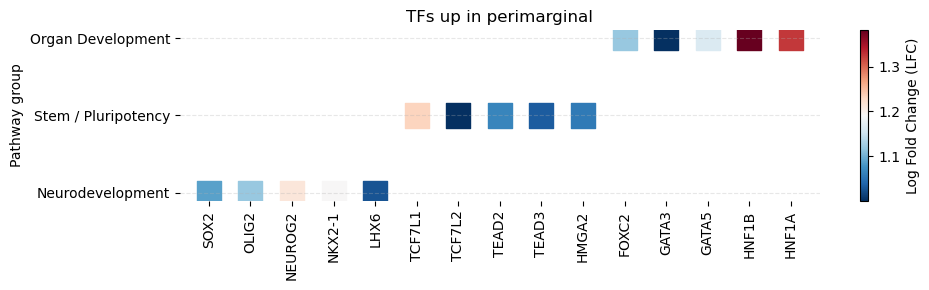

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- 1. pick genes per group ----
group_genes = {
    # "Immune-related": ["IRF6", "IKZF2", "IKZF4", "NFATC1", "EOMES"],
    "Neurodevelopment": ["SOX2", "OLIG2", "NEUROG2", "NKX2-1", "LHX6"],
    "Stem / Pluripotency": ["TCF7L1", "TCF7L2", "TEAD2", "TEAD3", "HMGA2"],
    "Organ Development": ["FOXC2", "GATA3", "GATA5", "HNF1B", "HNF1A"]
}

# keep padj < 0.01 (same as before)
significant = peri_motifs[peri_motifs["padj"] < 0.01].copy()

# make sure gene name column is called "gene"
if "index" in significant.columns:
    significant = significant.rename(columns={"index": "gene"})

# ---- 2. collect data in the desired order (1,2,4,5) ----
genes_order = []
groups_order = []
lfc_values = []

for gname in ["Neurodevelopment", "Stem / Pluripotency", 
              "Organ Development"]:
    for gene in group_genes[gname]:
        row = significant[significant["gene"] == gene]
        if not row.empty:
            genes_order.append(gene)
            groups_order.append(gname)
            lfc_values.append(float(row["LFC"].iloc[0]))
        # if gene not in significant, it is skipped silently # "Immune-related" 

# convert to arrays #  "Immune-related"
x = np.arange(len(genes_order))
group_ids = {g: i for i, g in enumerate(
    ["Neurodevelopment", "Stem / Pluripotency",
     "Organ Development"] 
)}
y = np.array([group_ids[g] for g in groups_order])
lfc_values = np.array(lfc_values)

# ---- 3. plot as colored squares ----
plt.figure(figsize=(10, 3))

sc = plt.scatter(
    x, y,
    c=lfc_values,
    cmap="RdBu_r",     # blue=down, red=up
    marker="s",
    s=300           # square size
)

# axes & labels
plt.xticks(x, genes_order, rotation=90)
plt.yticks(list(group_ids.values()), list(group_ids.keys()))
plt.ylabel("Pathway group")
plt.title("TFs up in perimarginal")

# colorbar
cbar = plt.colorbar(sc)
cbar.set_label("Log Fold Change (LFC)")

# clean style
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()


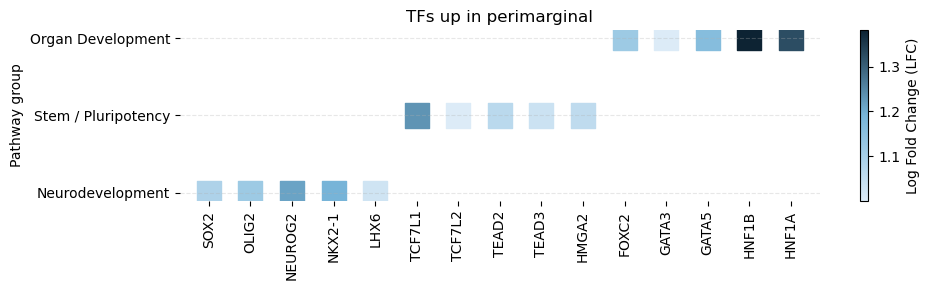

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# ---- custom single-color gradient ----
base = "#77b5d9"  # Peri color

# light → base → dark  (so higher numbers appear darker)
cmap_custom = mcolors.LinearSegmentedColormap.from_list(
    "peri_gradient",
    ["#dcebf7", base, "#0d2333"]
)

# ---- your existing plotting code ----

plt.figure(figsize=(10, 3))

sc = plt.scatter(
    x, y,
    c=lfc_values,
    cmap=cmap_custom,   # <<--- UPDATED
    marker="s",
    s=300
)

plt.xticks(x, genes_order, rotation=90)
plt.yticks(list(group_ids.values()), list(group_ids.keys()))
plt.ylabel("Pathway group")
plt.title("TFs up in perimarginal")

cbar = plt.colorbar(sc)
cbar.set_label("Log Fold Change (LFC)")

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()


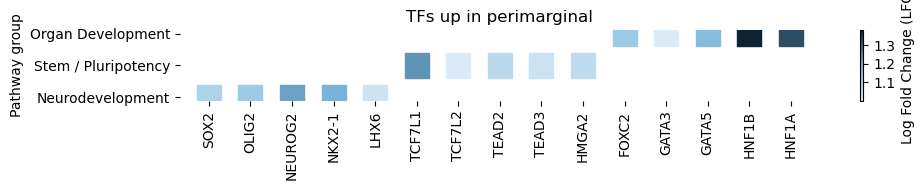

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# ---- custom single-color gradient ----
base = "#77b5d9"  # Peri color

# light → base → dark  (بزرگ‌تر = تیره‌تر)
cmap_custom = mcolors.LinearSegmentedColormap.from_list(
    "peri_gradient",
    ["#dcebf7", base, "#0d2333"]
)

plt.figure(figsize=(10, 2))

sc = plt.scatter(
    x, y,
    c=lfc_values,
    cmap=cmap_custom,
    marker="s",
    s=300
)

plt.xticks(x, genes_order, rotation=90)
plt.yticks(list(group_ids.values()), list(group_ids.keys()))
plt.ylabel("Pathway group")
plt.title("TFs up in perimarginal")

cbar = plt.colorbar(sc)
cbar.set_label("Log Fold Change (LFC)")

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)

# ❌ این خط رو حذف کردیم که بک‌گراند دَش‌دار نباشه
# ax.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()


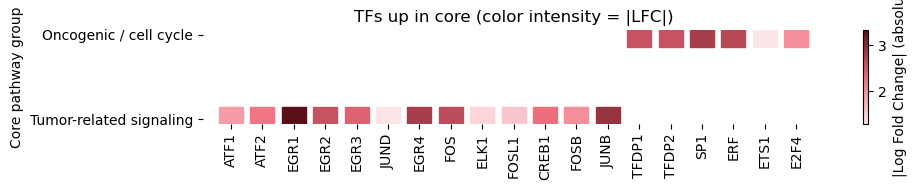

In [20]:
import matplotlib.colors as mcolors

core_base = "#ef6c7c"   # your CORE pink color

# dark → base → light
core_cmap = mcolors.LinearSegmentedColormap.from_list(
    "core_gradient",
    ["#5a0f18", core_base, "#fde6e9"]   # dark red → core color → light pink
)



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- 1. pick genes per group (CORE, pathway-based) ----
group_genes = {
    "Tumor-related signaling": [
        "ATF1", "ATF2", "EGR1", "EGR2", "EGR3", "JUND",
        "EGR4", "FOS", "ELK1", "FOSL1", "CREB1", "FOSB", "JUNB"
    ],

    "Oncogenic / cell cycle": [
        "TFDP1", "TFDP2", "SP1", "ERF", "ETS1", "E2F4"
    ],
}

# keep padj < 0.01
significant = peri_motifs[peri_motifs["padj"] < 0.01].copy()

if "index" in significant.columns:
    significant = significant.rename(columns={"index": "gene"})

# ---- 2. collect data ----
genes_order = []
groups_order = []
lfc_values = []

for gname in [
    "Tumor-related signaling",
    "Oncogenic / cell cycle"
]:
    for gene in group_genes[gname]:
        row = significant[significant["gene"] == gene]
        if not row.empty:
            genes_order.append(gene)
            groups_order.append(gname)

            # 🔴 NEW: use absolute LFC for color intensity
            abs_lfc = abs(float(row["LFC"].iloc[0]))
            lfc_values.append(abs_lfc)

# convert to arrays
x = np.arange(len(genes_order))
group_ids = {g: i for i, g in enumerate([
    "Tumor-related signaling",
    "Oncogenic / cell cycle"
])}
y = np.array([group_ids[g] for g in groups_order])
lfc_values = np.array(lfc_values)

# ---- 3. plot ----
plt.figure(figsize=(10, 2))

sc = plt.scatter(
    x, y,
    c=lfc_values,            # now absolute values
    cmap=core_cmap.reversed(),
    marker="s",
    s=300
)

plt.xticks(x, genes_order, rotation=90)
plt.yticks(list(group_ids.values()), list(group_ids.keys()))
plt.ylabel("Core pathway group")
plt.title("TFs up in core (color intensity = |LFC|)")

# colorbar
cbar = plt.colorbar(sc)
cbar.set_label("|Log Fold Change| (absolute)")

# clean style
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()
